## Approche dimensionnelle

In [585]:
import pandas as pd

df = pd.read_csv("../data/raw/tayaratn_data.csv")
df.head()

,title,price,type,transaction_type,surface,bathrooms,rooms,options,description,location,date_posted,image_url,agency,url,scrape_date
0,📍MENZAH 9 C : APPARTEMENT S+2 À LOUER,1400.0,NaN,À Louer,NaN,2.0,2.0,[],L’agence #MON_RESEAU met à la location un app...,Tunis,NaN,https://www.tayara.tn/mediaGateway/resize-imag...,NaN,https://www.tayara.tn/item/appartements/tunis/...,2025-11-25
1,A vendre un S+3 à cité essaha,180000.0,NaN,À Vendre,121.0,1.0,3.0,[],IB-4400\noffre valable jusqu'au 31 Décembre.\n...,Ariana,NaN,https://www.tayara.tn/mediaGateway/resize-imag...,first home real estate,https://www.tayara.tn/item/appartements/ariana...,2025-11-25
2,📍 ENNASR 1 – APPARTEMENT S+4 TRANSFORMÉ EN S+3...,430000.0,NaN,À Vendre,145.0,2.0,4.0,[],L’agence MON_RÈSEAU IMMOBILIER vous propose à ...,Ariana,NaN,https://www.tayara.tn/mediaGateway/resize-imag...,NaN,https://www.tayara.tn/item/appartements/ariana...,2025-11-25
3,Terrain à vendre - Mahdia Tunisie,450000.0,NaN,NaN,NaN,NaN,NaN,[],Une opportunité idéale \n\nTerrain exceptionne...,Mahdia,NaN,https://www.tayara.tn/mediaGateway/resize-imag...,remax masters,https://www.tayara.tn/item/terrains-et-fermes/...,2025-11-25
4,A vendre Triplex la soukra,NaN,NaN,À Vendre,289.0,3.0,4.0,[],💒Gest-Immo Logistique se propose de vendre Tri...,Ariana,NaN,https://www.tayara.tn/mediaGateway/resize-imag...,gest immo logistique,https://www.tayara.tn/item/appartements/ariana...,2025-11-25


In [586]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9717 entries, 0 to 9716
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             9717 non-null   object 
 1   price             8504 non-null   float64
 2   type              207 non-null    object 
 3   transaction_type  7861 non-null   object 
 4   surface           7434 non-null   float64
 5   bathrooms         7123 non-null   float64
 6   rooms             7326 non-null   float64
 7   options           9717 non-null   object 
 8   description       9696 non-null   object 
 9   location          9717 non-null   object 
 10  date_posted       7453 non-null   object 
 11  image_url         9717 non-null   object 
 12  agency            5532 non-null   object 
 13  url               9717 non-null   object 
 14  scrape_date       9717 non-null   object 
dtypes: float64(4), object(11)
memory usage: 1.1+ MB


### La complétude (Completeness)

In [587]:
completeness = df.isnull().mean() * 100
completeness

title                0.000000
price               12.483277
type                97.869713
transaction_type    19.100545
surface             23.494906
bathrooms           26.695482
rooms               24.606360
options              0.000000
description          0.216116
location             0.000000
date_posted         23.299372
image_url            0.000000
agency              43.068848
url                  0.000000
scrape_date          0.000000
dtype: float64

In [588]:
non_empty_options = df['options'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False).sum()
print("Nombre d'annonces avec options non vides :", non_empty_options)

Nombre d'annonces avec options non vides : 0


=> Les champs qui manquent ne sont pas exigées par le site tayara.tn .

Pour notre analyse, la colonne "price" est essentielle => on va dropper les lignes manquantes.

In [589]:
df = df.dropna(subset=["price"])

In [590]:
df = df.drop(columns=['options'])

In [591]:
df["agency"] = df["agency"].fillna("particulier")

In [592]:
def extract_transaction_type(title, existing_value):
    title = title.lower()

    if "louer" in title or "location" in title:
        return "À Louer"
    if "vendre" in title or "vente" in title:
        return "À Vendre"

    return existing_value if pd.notna(existing_value) else "Unknown"

df["transaction_type"] = df.apply(
    lambda row: extract_transaction_type(row["title"], row["transaction_type"]),
    axis=1
)

In [593]:
def extract_property_type(title):
    title = title.lower()
    
    # Dictionnaire de mapping keyword => type standard
    mapping = {
        'appartement': 'Appartement',
        's+': 'Appartement',   # S+2, S+3, S+4 = Appartement
        'villa': 'Villa',
        'terrain': 'Terrain',
        'studio': 'Studio',
        'triplex': 'Triplex',
        'duplex': 'Duplex',
        'maison': 'Maison',
        'ferme': 'Ferme',
        'bureau': 'Bureau',
    }
    
    for key, value in mapping.items():
        if key in title:
            return value
        if 'coworking' in title or 'travail' in title:
            return 'Bureau'

    return 'Unknown'

df['type'] = df['title'].apply(extract_property_type)

print(df['type'].value_counts(dropna=False))

type
Appartement    3658
Unknown        1969
Terrain         968
Villa           756
Bureau          594
Maison          242
Studio          166
Duplex          109
Ferme            23
Triplex          19
Name: count, dtype: int64


In [594]:
import pandas as pd
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")
df[["surface", "rooms", "bathrooms"]] = num_imputer.fit_transform(
    df[["surface", "rooms", "bathrooms"]]
)

In [595]:
df["date_posted"] = df["date_posted"].fillna("Unknown")

In [596]:
df['description'] = df['description'].fillna('')

In [597]:
print(df.isnull().mean() * 100)

title               0.0
price               0.0
type                0.0
transaction_type    0.0
surface             0.0
bathrooms           0.0
rooms               0.0
description         0.0
location            0.0
date_posted         0.0
image_url           0.0
agency              0.0
url                 0.0
scrape_date         0.0
dtype: float64


Notre dataset est complet.

### La précision (Accuracy)

In [598]:
df[df['price'] < 0].sum()

title                 0
price               0.0
type                  0
transaction_type      0
surface             0.0
bathrooms           0.0
rooms               0.0
description           0
location              0
date_posted           0
image_url             0
agency                0
url                   0
scrape_date           0
dtype: object

In [599]:
df[df['price'] > 1e9]

,title,price,type,transaction_type,surface,bathrooms,rooms,description,location,date_posted,image_url,agency,url,scrape_date
1076,Opportunité exceptionnelle : Local commercial ...,1.600000e+09,Unknown,À Vendre,2.000000e+02,2.0,2.0,Opportunité exceptionnelle pour les investisse...,Nabeul,Unknown,https://www.tayara.tn/mediaGateway/resize-imag...,city casa,https://www.tayara.tn/item/magasins%2c-commerc...,2025-11-25
1447,Villa de prestige a ALAIN SAVARY Tunis,2.100000e+09,Villa,À Vendre,4.500000e+02,1.0,8.0,"Villa de Prestige à Vendre – Alain Savary, Tun...",Tunis,Unknown,https://www.tayara.tn/mediaGateway/resize-imag...,agence immobiliere sonis immo,https://www.tayara.tn/item/maisons-et-villas/t...,2025-11-25
1967,Terrain menzah 5,1.500000e+09,Terrain,Unknown,1.110000e+02,1.0,2.0,Notre agence le palais\nmet a la vente d'un te...,Ariana,2025-11-22,https://www.tayara.tn/mediaGateway/resize-imag...,particulier,https://www.tayara.tn/item/terrains-et-fermes/...,2025-11-25
3336,IMMEUBLE KANTAOUI,1.485000e+09,Unknown,À Vendre,4.000000e+02,7.0,11.0,Tel : Afficher le numéro Propriétaire…Merci j’...,Sousse,2025-11-18,https://www.tayara.tn/mediaGateway/resize-imag...,particulier,https://www.tayara.tn/item/maisons-et-villas/s...,2025-11-25
3536,عمارة ذات ثلاث طوابق كل طابق فيه 2 شقق في حي ا...,1.100000e+09,Unknown,À Vendre,3.300000e+02,6.0,12.0,عمارة ذات ثلاث طوابق كل طابق فيه 2 شقق وكل شقة...,Nabeul,2025-11-18,https://www.tayara.tn/mediaGateway/resize-imag...,city casa,https://www.tayara.tn/item/maisons-et-villas/n...,2025-11-25
5684,vente villa spacieuse à 4 étages pieds dans l'eau,1.900000e+09,Villa,À Vendre,1.650000e+03,5.0,6.0,"une villa spacieuse à 4 étages avec piscine ,...",Sousse,2025-11-10,https://www.tayara.tn/mediaGateway/resize-imag...,particulier,https://www.tayara.tn/item/maisons-et-villas/s...,2025-11-25
8675,garage,1.000000e+12,Unknown,À Vendre,9.856556e+10,1.0,1.0,garage 231 mettre,Gabès,Unknown,https://www.tayara.tn/mediaGateway/resize-imag...,particulier,https://www.tayara.tn/item/magasins%2c-commerc...,2025-11-25
8906,📍 À VENDRE – Ferme Agricole de 13 Hectares à R...,1.600000e+09,Ferme,À Vendre,1.110000e+02,1.0,2.0,Agence Basma Immobilière 💛💙 vous propose à la ...,Kairouan,Unknown,https://www.tayara.tn/mediaGateway/resize-imag...,basma immo,https://www.tayara.tn/item/terrains-et-fermes/...,2025-11-25
8935,📍 À VENDRE – Ferme Agricole de 10 Hectares à E...,1.300000e+09,Ferme,À Vendre,1.110000e+02,1.0,2.0,Agence Basma Immobilière 💙💛vous propose à la v...,Sousse,Unknown,https://www.tayara.tn/mediaGateway/resize-imag...,basma immo,https://www.tayara.tn/item/terrains-et-fermes/...,2025-11-25
8939,📍À Vendre – Superbe Villa Style Américain à Sa...,1.600000e+09,Villa,À Vendre,3.900000e+02,3.0,5.0,AGENCE BASMA IMMOBILIERE 💛💙 vous proposer à la...,Sousse,Unknown,https://www.tayara.tn/mediaGateway/resize-imag...,basma immo,https://www.tayara.tn/item/maisons-et-villas/s...,2025-11-25


In [600]:
df[df['title'].str.lower().isin(['n/a','unknown','test', ''])].sum()

title                 0
price               0.0
type                  0
transaction_type      0
surface             0.0
bathrooms           0.0
rooms               0.0
description           0
location              0
date_posted           0
image_url             0
agency                0
url                   0
scrape_date           0
dtype: object

In [601]:
df['type'].value_counts()

type
Appartement    3658
Unknown        1969
Terrain         968
Villa           756
Bureau          594
Maison          242
Studio          166
Duplex          109
Ferme            23
Triplex          19
Name: count, dtype: int64

In [602]:
df = df[(df['rooms'] <= 20) & 
                    (df['bathrooms'] <= 20)]

In [603]:
df = df[(df['surface'] <= 2000)]

### La conformité (Validity)

In [604]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['surface'] = pd.to_numeric(df['surface'], errors='coerce')
df['rooms'] = pd.to_numeric(df['rooms'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

In [605]:
df['date_posted'] = df['date_posted'].replace('Unknown', pd.NaT)
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
df['scrape_date'] = pd.to_datetime(df['scrape_date'], errors='coerce')

In [606]:
print(df.dtypes)

title                       object
price                      float64
type                        object
transaction_type            object
surface                    float64
bathrooms                  float64
rooms                      float64
description                 object
location                    object
date_posted         datetime64[ns]
image_url                   object
agency                      object
url                         object
scrape_date         datetime64[ns]
dtype: object


### La cohérence (Consistency)

In [607]:
import pandas as pd

# --- Surface incohérente selon type ---
bad_surface = df[
    ((df['type'] != 'Terrain') & ((df['surface'] <= 0) | (df['surface'] > 10000))) |
    ((df['type'] == 'Terrain') & ((df['surface'] <= 0) | (df['surface'] > 50000)))
]

# --- Nombre de chambres incohérent selon type ---
bad_rooms = df[
    (((df['type'].isin(['Appartement', 'Studio'])) & (df['rooms'] <= 0))) |
    ((df['type'] == 'Terrain') & (df['rooms'] > 0)) |
    (((df['type'].isin(['Villa', 'Maison', 'Duplex', 'Triplex'])) & (df['rooms'] <= 0)))
]

# --- Nombre de salles de bain incohérent ---
bad_bathrooms = df[
    (((df['type'].isin(['Appartement', 'Villa', 'Maison', 'Duplex', 'Triplex'])) & (df['bathrooms'] <= 0))) |
    ((df['type'] == 'Terrain') & (df['bathrooms'] > 0))
]

# --- Prix incohérent selon transaction_type ---
bad_price = df[
    ((df['transaction_type'] == 'À Louer') & (df['price'] > 50000)) |
    ((df['transaction_type'] == 'À Vendre') & (df['price'] < 1000))
]

# --- Date incohérente (date_posted après scrape_date) ---
bad_dates = df[df['date_posted'] > df['scrape_date']]

# --- Surface trop petite vs nombre de pièces (ex: studio de 2 pièces?) ---
bad_surface_rooms = df[(df['surface'] < 10) & (df['rooms'] > 1)]

# --- Concaténer toutes les incohérences et supprimer les doublons ---
inconsistent_rows = pd.concat([
    bad_surface, bad_rooms, bad_bathrooms, bad_price, bad_dates, bad_surface_rooms
]).drop_duplicates()

print(f"Nombre d'annonces incohérentes : {len(inconsistent_rows)}")

Nombre d'annonces incohérentes : 1423


In [608]:
# Surface incohérente selon type
df.loc[(df['type'] != 'Terrain') & (df['surface'] <= 0), 'surface'] = df.loc[df['type'] != 'Terrain', 'surface'].median()
df.loc[(df['type'] != 'Terrain') & (df['surface'] > 10000), 'surface'] = df.loc[df['type'] != 'Terrain', 'surface'].median()
df.loc[(df['type'] == 'Terrain') & (df['surface'] <= 0), 'surface'] = df.loc[df['type'] == 'Terrain', 'surface'].median()
df.loc[(df['type'] == 'Terrain') & (df['surface'] > 50000), 'surface'] = df.loc[df['type'] == 'Terrain', 'surface'].median()

# Rooms incohérentes
df.loc[(df['type'].isin(['Appartement','Studio','Villa','Maison','Duplex','Triplex'])) & (df['rooms'] <= 0), 'rooms'] = df['rooms'].median()
df.loc[(df['type'] == 'Terrain') & (df['rooms'] > 0), 'rooms'] = 0

# Bathrooms incohérents
df.loc[(df['type'].isin(['Appartement','Villa','Maison','Duplex','Triplex'])) & (df['bathrooms'] <= 0), 'bathrooms'] = df['bathrooms'].median()
df.loc[(df['type'] == 'Terrain') & (df['bathrooms'] > 0), 'bathrooms'] = 0

# Prix incohérent
df.loc[(df['transaction_type'] == 'À Louer') & (df['price'] > 50000), 'price'] = df.loc[df['transaction_type'] == 'À Louer', 'price'].median()
df.loc[(df['transaction_type'] == 'À Vendre') & (df['price'] < 1000), 'price'] = df.loc[df['transaction_type'] == 'À Vendre', 'price'].median()

# Date incohérente
df.loc[df['date_posted'] > df['scrape_date'], 'date_posted'] = df['scrape_date']

# Surface trop petite vs rooms
df.loc[(df['surface'] < 10) & (df['rooms'] > 1), 'surface'] = df['surface'].median()

In [609]:
# Vérification finale des incohérences ---
inconsistent_rows = pd.concat([
    df[((df['type'] != 'Terrain') & ((df['surface'] <= 0) | (df['surface'] > 10000))) |
       ((df['type'] == 'Terrain') & ((df['surface'] <= 0) | (df['surface'] > 50000)))],
    df[((df['type'].isin(['Appartement','Studio','Villa','Maison','Duplex','Triplex'])) & (df['rooms'] <= 0)) |
       ((df['type'] == 'Terrain') & (df['rooms'] > 0))],
    df[((df['type'].isin(['Appartement','Villa','Maison','Duplex','Triplex'])) & (df['bathrooms'] <= 0)) |
       ((df['type'] == 'Terrain') & (df['bathrooms'] > 0))],
    df[((df['transaction_type'] == 'À Louer') & (df['price'] > 50000)) |
       ((df['transaction_type'] == 'À Vendre') & (df['price'] < 1000))],
    df[df['date_posted'] > df['scrape_date']],
    df[(df['surface'] < 10) & (df['rooms'] > 1)]
]).drop_duplicates()

print(f"Nombre d'annonces encore incohérentes après nettoyage : {len(inconsistent_rows)}")

Nombre d'annonces encore incohérentes après nettoyage : 0


### L’actualité (Timeliness)

In [610]:
df['scrape_date'] = pd.to_datetime(df['scrape_date'], errors='coerce')
today = pd.to_datetime('today')
max_age_days = 30
stale_data = df[df['scrape_date'] < (today - pd.Timedelta(days=max_age_days))]

print(f"Nombre de lignes avec données trop anciennes (> {max_age_days} jours) : {len(stale_data)}")

Nombre de lignes avec données trop anciennes (> 30 jours) : 0


### La pertinence 

In [611]:
df.columns

Index(['title', 'price', 'type', 'transaction_type', 'surface', 'bathrooms',
       'rooms', 'description', 'location', 'date_posted', 'image_url',
       'agency', 'url', 'scrape_date'],
      dtype='object')

In [612]:
cols_keep = ['price', 'type', 'transaction_type', 'surface', 'rooms', 'bathrooms', 'location']
df_clean = df[cols_keep].copy()

### L’unicité (Uniqueness)

In [613]:
print(f"Lignes totales: {len(df_clean)}")
print(f"Lignes uniques: {df_clean.drop_duplicates().shape[0]}")
print(f"Doublons: {len(df_clean) - df_clean.drop_duplicates().shape[0]}")
print(f"Taux d'unicité: {(df_clean.drop_duplicates().shape[0] / len(df_clean)) * 100:.2f}%")

Lignes totales: 8394
Lignes uniques: 7547
Doublons: 847
Taux d'unicité: 89.91%


In [614]:
df_clean = df_clean.drop_duplicates().reset_index(drop=True)

In [615]:
print(f"Lignes totales: {len(df_clean)}")
print(f"Lignes uniques: {df_clean.drop_duplicates().shape[0]}")
print(f"Doublons: {len(df_clean) - df_clean.drop_duplicates().shape[0]}")
print(f"Taux d'unicité: {(df_clean.drop_duplicates().shape[0] / len(df_clean)) * 100:.2f}%")

Lignes totales: 7547
Lignes uniques: 7547
Doublons: 0
Taux d'unicité: 100.00%


### La clarté (Clarity)

In [616]:
df_clean.columns

Index(['price', 'type', 'transaction_type', 'surface', 'rooms', 'bathrooms',
       'location'],
      dtype='object')

In [617]:
df_clean = df_clean.rename(columns={
    'price': 'property_price',
    'type': 'property_type',
    'transaction_type': 'transaction_type',
    'surface': 'property_surface_m2',
    'rooms': 'number_of_rooms',
    'bathrooms': 'number_of_bathrooms',
    'location': 'property_location'
})

In [618]:
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7547 entries, 0 to 7546
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_price       7547 non-null   float64
 1   property_type        7547 non-null   object 
 2   transaction_type     7547 non-null   object 
 3   property_surface_m2  7547 non-null   float64
 4   number_of_rooms      7547 non-null   float64
 5   number_of_bathrooms  7547 non-null   float64
 6   property_location    7547 non-null   object 
dtypes: float64(4), object(3)
memory usage: 412.9+ KB


,property_price,property_type,transaction_type,property_surface_m2,number_of_rooms,number_of_bathrooms,property_location
0,1400.0,Appartement,À Louer,111.0,2.0,2.0,Tunis
1,180000.0,Appartement,À Vendre,121.0,3.0,1.0,Ariana
2,430000.0,Appartement,À Vendre,145.0,4.0,2.0,Ariana
3,450000.0,Terrain,À Vendre,111.0,0.0,0.0,Mahdia
4,690000.0,Terrain,À Vendre,111.0,0.0,0.0,Sousse


## Transformation des données

In [619]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

num_cols = ['property_surface_m2', 'number_of_rooms', 'number_of_bathrooms']

# --- Normalisation Min-Max ---
minmax_scaler = MinMaxScaler()
df_clean[[col + '_minmax' for col in num_cols]] = minmax_scaler.fit_transform(df_clean[num_cols])

# --- Standardisation (Z-score) ---
std_scaler = StandardScaler()
df_clean[[col + '_std' for col in num_cols]] = std_scaler.fit_transform(df_clean[num_cols])

## Réduction des données

In [620]:
cat_cols = ['property_type', 'property_location']

In [621]:
print(df_clean['transaction_type'].unique())

['À Louer' 'À Vendre' 'Unknown' 'sale']


In [622]:
# Filtrer les lignes où transaction_type == 'sale'
sale_rows = df[df['transaction_type'].str.lower() == 'sale']
print(sale_rows)

                                                  title     price     type  \
8663  للبيع طابق علوي مستقل به 3 غرف  وفوقه ستيديو ع...  200000.0  Unknown   

     transaction_type  surface  bathrooms  rooms description location  \
8663             sale    175.0        1.0    3.0                 Sfax   

     date_posted                                          image_url  \
8663         NaT  https://www.tayara.tn/mediaGateway/resize-imag...   

           agency                                                url  \
8663  particulier  https://www.tayara.tn/item/maisons-et-villas/s...   

     scrape_date  
8663  2025-11-25  


In [623]:
df_clean['transaction_type'] = df_clean['transaction_type'].replace({'sale': 'À Vendre'})

In [624]:
df_clean = df_clean[df_clean['transaction_type'] != 'À Louer'].copy()

print(f"Nombre d'annonces à vendre : {len(df_clean)}")
print(df_clean['transaction_type'].unique())

Nombre d'annonces à vendre : 3973
['À Vendre' 'Unknown']


In [625]:
df_clean.drop(columns=['transaction_type'], inplace=True)

In [626]:
print(df_clean['property_type'].unique())
print(df_clean['property_location'].unique())
print(len(df_clean['property_location'].unique()))

['Appartement' 'Terrain' 'Unknown' 'Villa' 'Bureau' 'Maison' 'Duplex'
 'Ferme' 'Studio' 'Triplex']
['Ariana' 'Mahdia' 'Sousse' 'tunis' 'Nabeul' 'Bizerte' 'Ben Arous' 'Tunis'
 'Zaghouan' 'La Manouba' 'sousse' 'Sfax' 'Monastir' 'ariana' 'sfax'
 'nabeul' 'Médenine' 'Gafsa' 'Béja' 'Kasserine' 'Kairouan' 'Gabès'
 'Le Kef' 'Jendouba' 'ben-arous' 'mahdia' 'Sidi Bouzid' 'Siliana'
 'la-manouba' 'Tozeur' 'monastir' 'gabès' 'Tataouine' 'jendouba']
34


In [627]:
# Nettoyage des noms de gouvernorats
df_clean['property_location'] = df_clean['property_location'].str.lower()  # tout en minuscules
df_clean['property_location'] = df_clean['property_location'].str.replace('-', ' ')  # remplacer les tirets par des espaces
df_clean['property_location'] = df_clean['property_location'].str.strip()  # enlever les espaces en début/fin

print(df_clean['property_location'].unique())
print(len(df_clean['property_location'].unique()))


['ariana' 'mahdia' 'sousse' 'tunis' 'nabeul' 'bizerte' 'ben arous'
 'zaghouan' 'la manouba' 'sfax' 'monastir' 'médenine' 'gafsa' 'béja'
 'kasserine' 'kairouan' 'gabès' 'le kef' 'jendouba' 'sidi bouzid'
 'siliana' 'tozeur' 'tataouine']
23


In [662]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Dataset 1 : One-Hot Encoding
ohe = OneHotEncoder()
encoded = ohe.fit_transform(df_clean[cat_cols])
encoded_df = pd.DataFrame(encoded.toarray(), columns=ohe.get_feature_names_out(cat_cols), index=df_clean.index)
df_ohe = pd.concat([df_clean, encoded_df], axis=1)
# drop original categorical cols
df_ohe = df_ohe.drop(columns=cat_cols)

In [663]:
# Dataset 2 : Label Encoding
df_le = df_clean.copy()
for col in cat_cols:
    le = LabelEncoder()
    df_le[col + '_le'] = le.fit_transform(df_le[col])
# drop original categorical cols
df_le = df_le.drop(columns=cat_cols)

In [664]:
print("OHE shape:", df_ohe.shape)
print("LE shape:", df_le.shape)

OHE shape: (3601, 43)
LE shape: (3601, 12)


In [665]:
df_ohe.to_csv('../data/clean/ohe_data.csv')
df_le.to_csv('../data/clean/le_data.csv')

# Visaualisation

In [632]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

In [633]:
num_cols_raw = ['property_price', 'property_surface_m2', 'number_of_rooms', 'number_of_bathrooms']
num_cols_minmax = ['property_surface_m2_minmax', 'number_of_rooms_minmax', 'number_of_bathrooms_minmax']
num_cols_std = ['property_surface_m2_std', 'number_of_rooms_std', 'number_of_bathrooms_std']

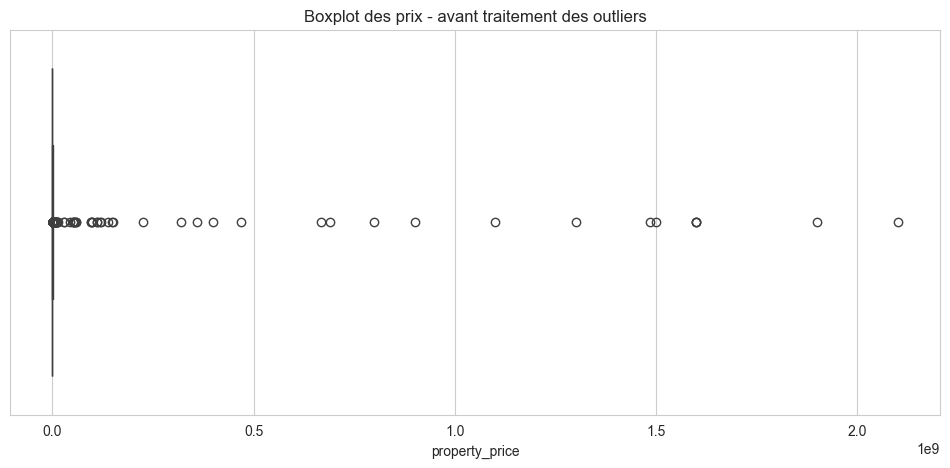

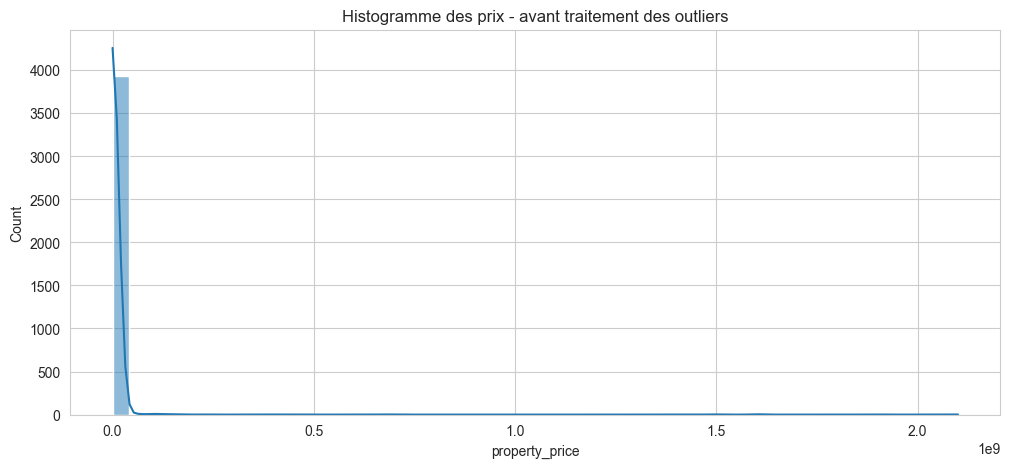

In [634]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.boxplot(x=df_clean['property_price'])
plt.title("Boxplot des prix - avant traitement des outliers")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df_clean['property_price'], bins=50, kde=True)
plt.title("Histogramme des prix - avant traitement des outliers")
plt.show()

In [635]:
Q1 = df_clean['property_price'].quantile(0.25)
Q3 = df_clean['property_price'].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = df_clean[(df_clean['property_price'] < Q1 - 1.5*IQR) | 
                        (df_clean['property_price'] > Q3 + 1.5*IQR)]
print(outliers_iqr[['property_price', 'property_type', 'property_location']])

      property_price property_type property_location
88         1190000.0       Unknown             tunis
105        1300000.0         Villa            ariana
132        1700000.0       Unknown             tunis
136        1050000.0       Terrain            ariana
180         899000.0   Appartement            nabeul
...              ...           ...               ...
7378       1064840.0       Unknown             tunis
7497       1261787.0   Appartement            ariana
7507       1153654.0   Appartement            ariana
7509       1148916.0   Appartement            ariana
7519        923000.0       Unknown         ben arous

[372 rows x 3 columns]


In [636]:
Q3 = df_clean['property_price'].quantile(0.75)
IQR = df_clean['property_price'].quantile(0.75) - df_clean['property_price'].quantile(0.25)

df_clean = df_clean[df_clean['property_price'] <= (Q3 + 1.5*IQR)]

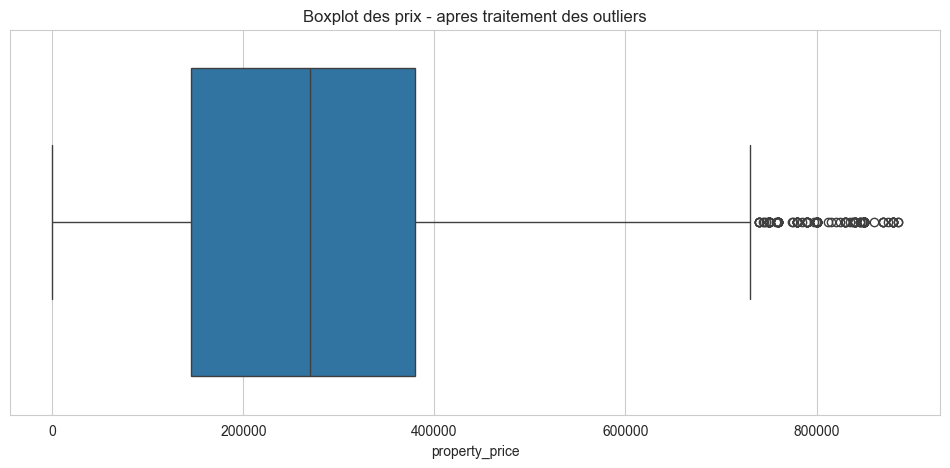

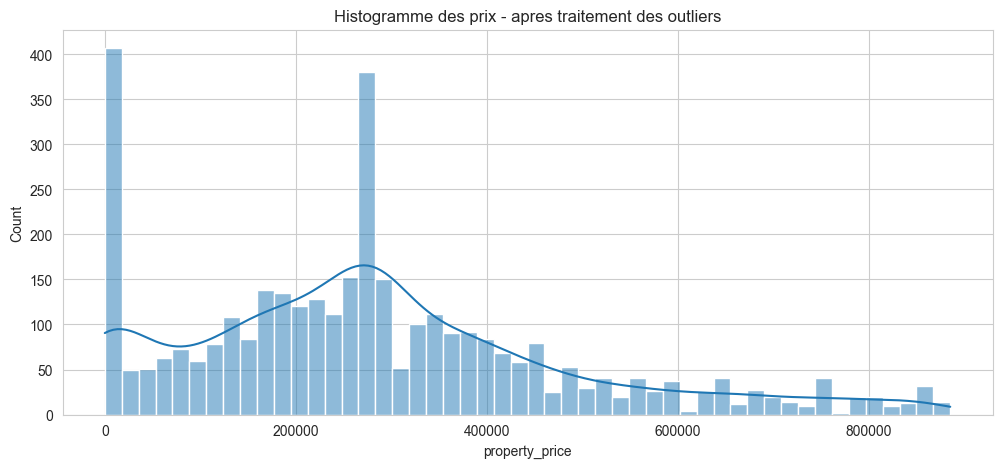

In [637]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.boxplot(x=df_clean['property_price'])
plt.title("Boxplot des prix - apres traitement des outliers")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df_clean['property_price'], bins=50, kde=True)
plt.title("Histogramme des prix - apres traitement des outliers")
plt.show()

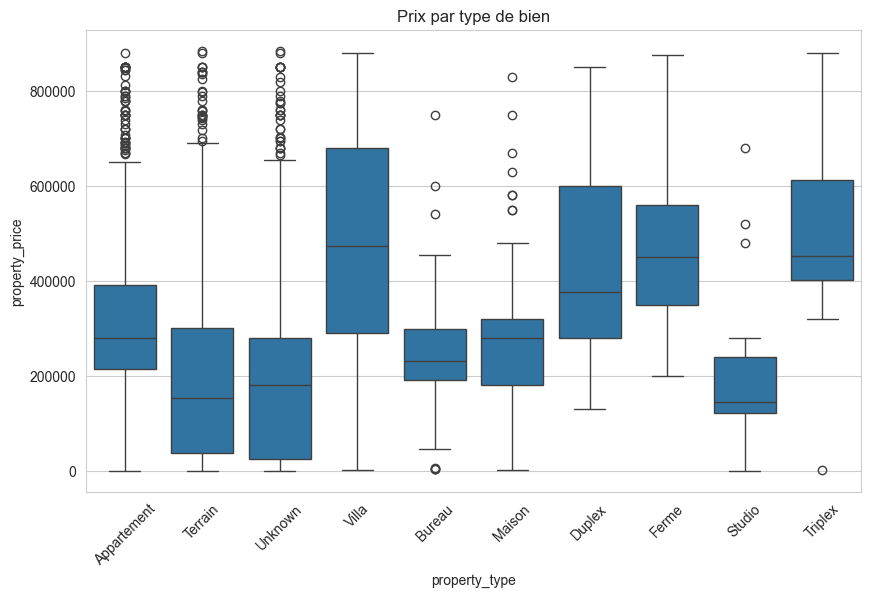

In [638]:
plt.figure()
sns.boxplot(x='property_type', y='property_price', data=df_clean)
plt.xticks(rotation=45)
plt.title('Prix par type de bien')
plt.show()

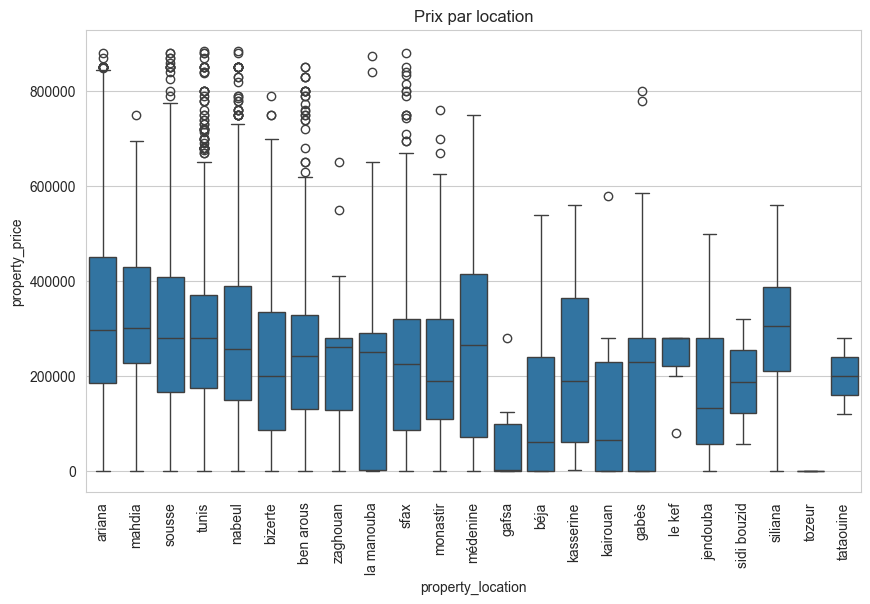

In [639]:
plt.figure()
sns.boxplot(x='property_location', y='property_price', data=df_clean)
plt.xticks(rotation=90)
plt.title('Prix par location')
plt.show()

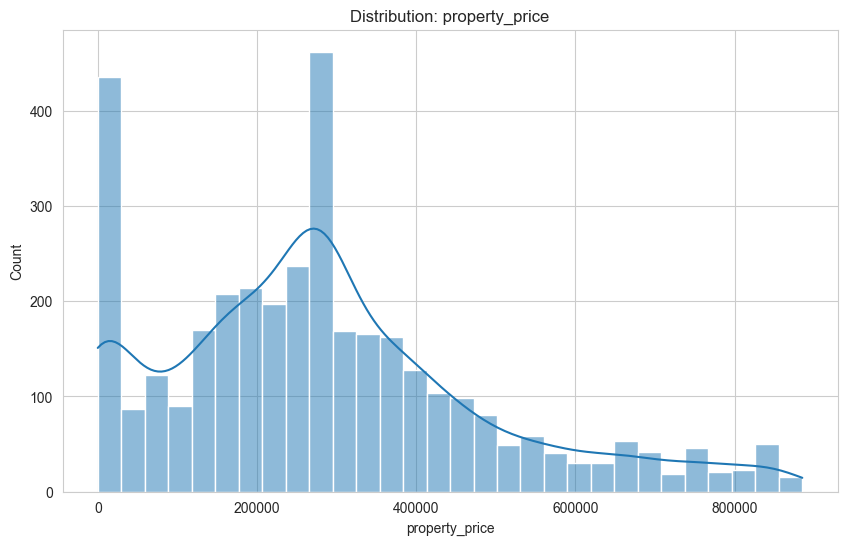

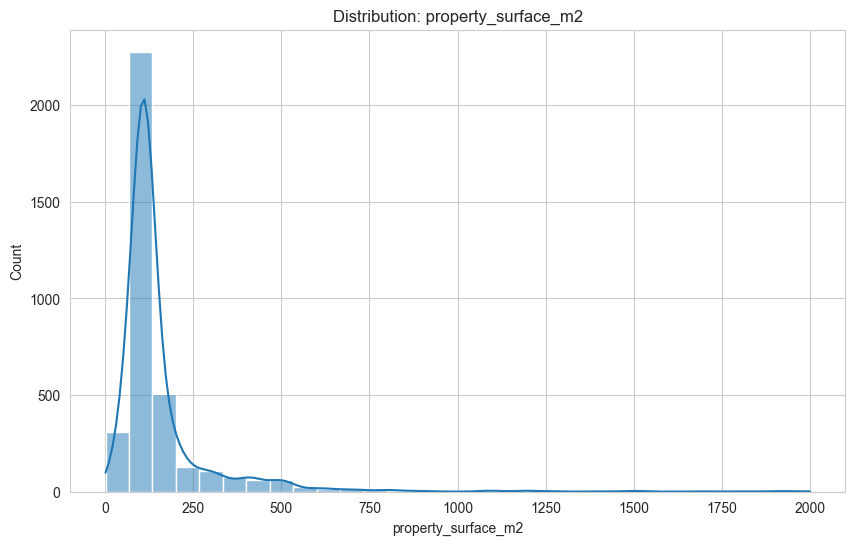

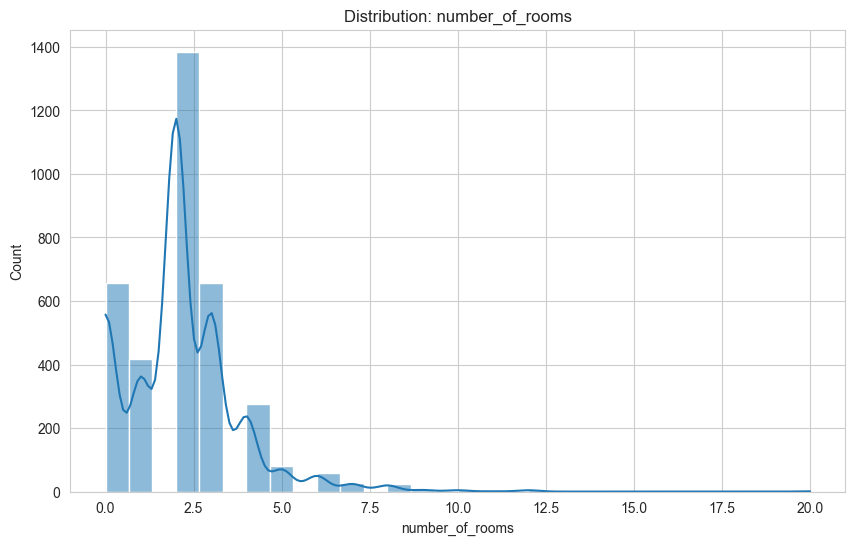

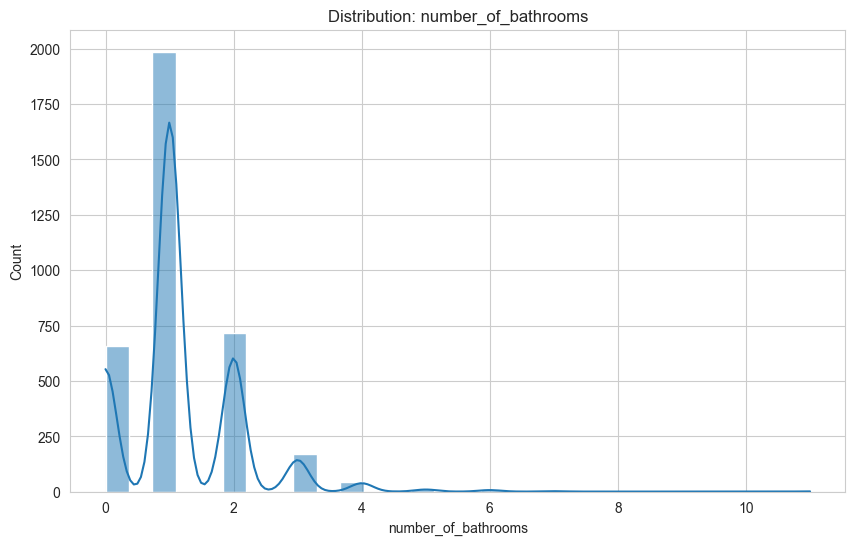

In [640]:
for col in num_cols_raw:
    plt.figure()
    sns.histplot(df_clean[col], kde=True, bins=30)
    plt.title(f'Distribution: {col}')
    plt.show()

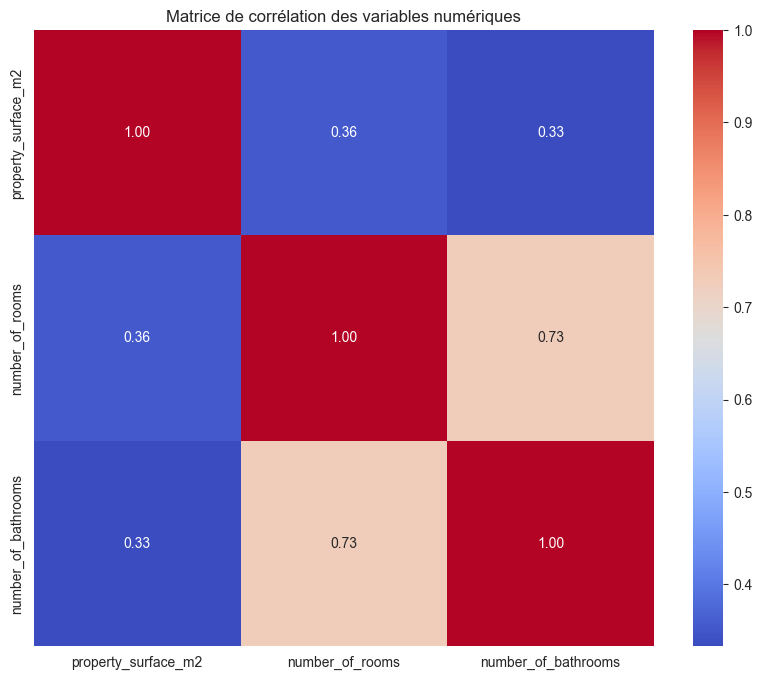

In [ ]:
plt.figure(figsize=(10,8))
corr = df_clean[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des variables numériques")
plt.show()

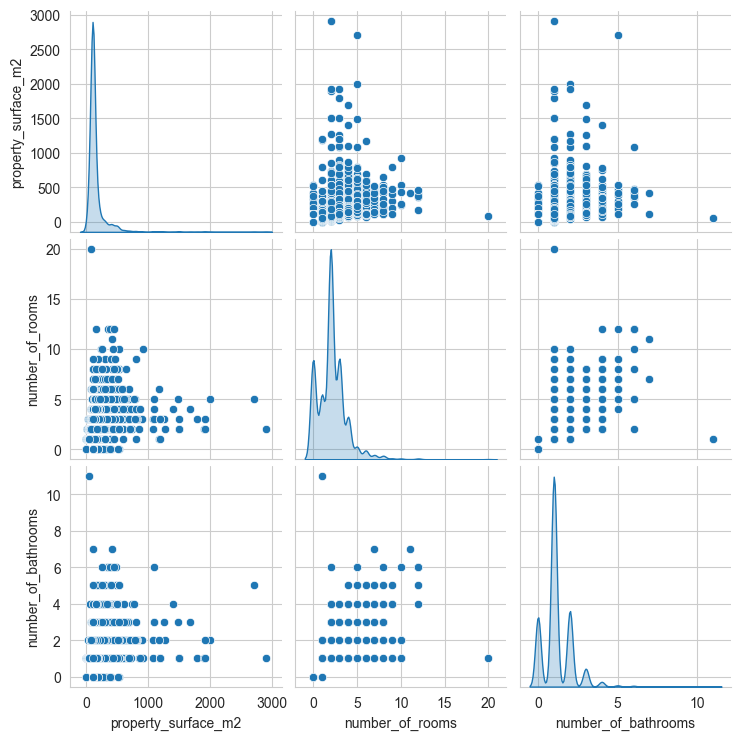

In [ ]:
sns.pairplot(df_clean[num_cols], kind='scatter', diag_kind='kde')
plt.show()

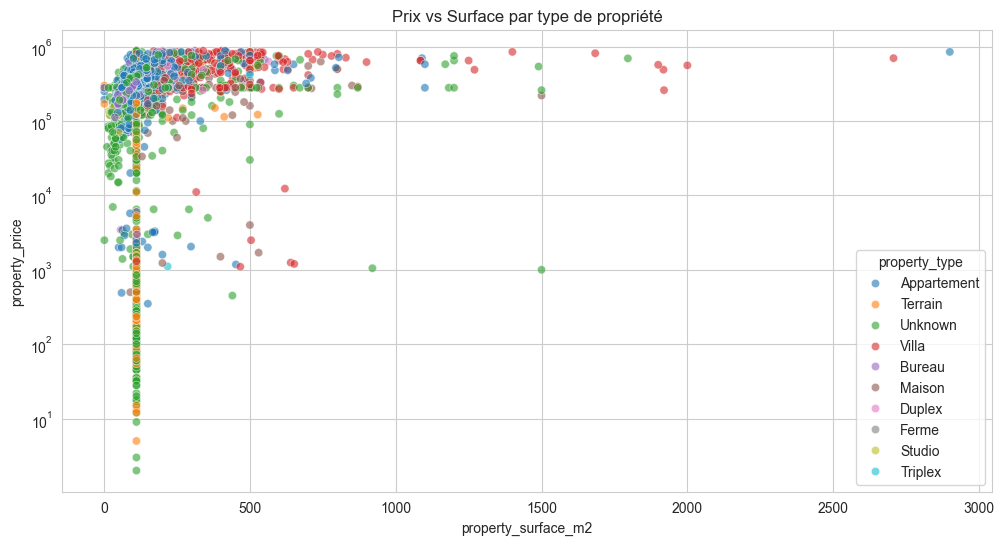

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='property_surface_m2', y='property_price', hue='property_type', alpha=0.6, data=df_clean)
plt.yscale('log')
plt.title("Prix vs Surface par type de propriété")
plt.show()

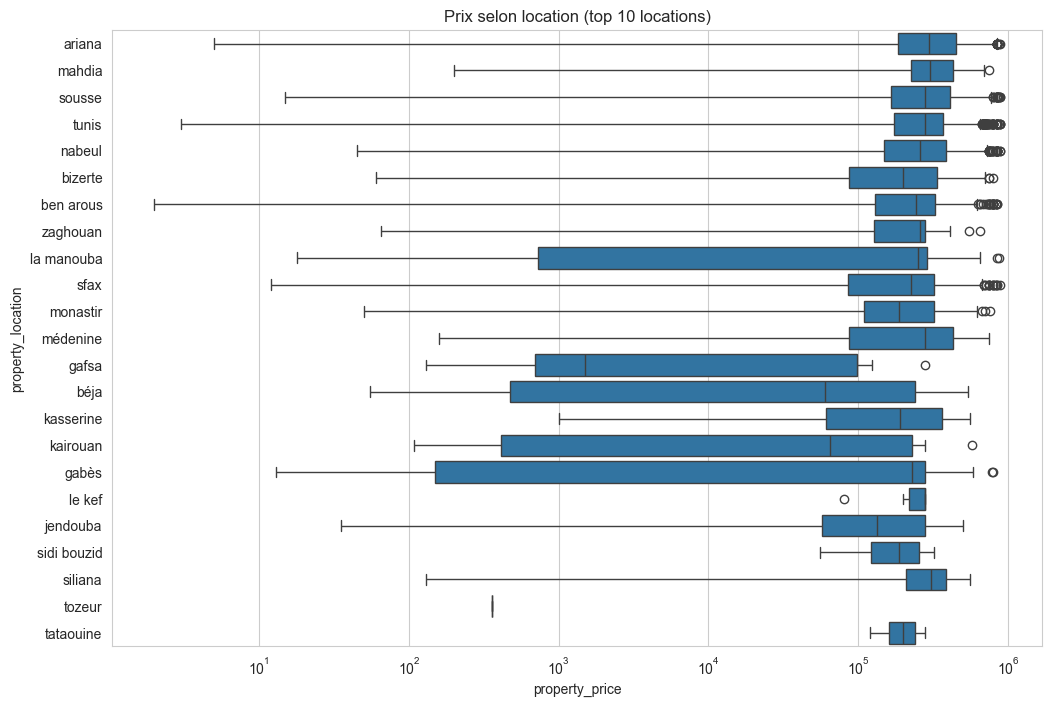

In [ ]:
top_locations = df_clean['property_location'].value_counts().index

plt.figure(figsize=(12,8))
sns.boxplot(x='property_price', y='property_location', data=df_clean[df_clean['property_location'].isin(top_locations)])
plt.xscale('log')
plt.title("Prix selon location (top 10 locations)")
plt.show()

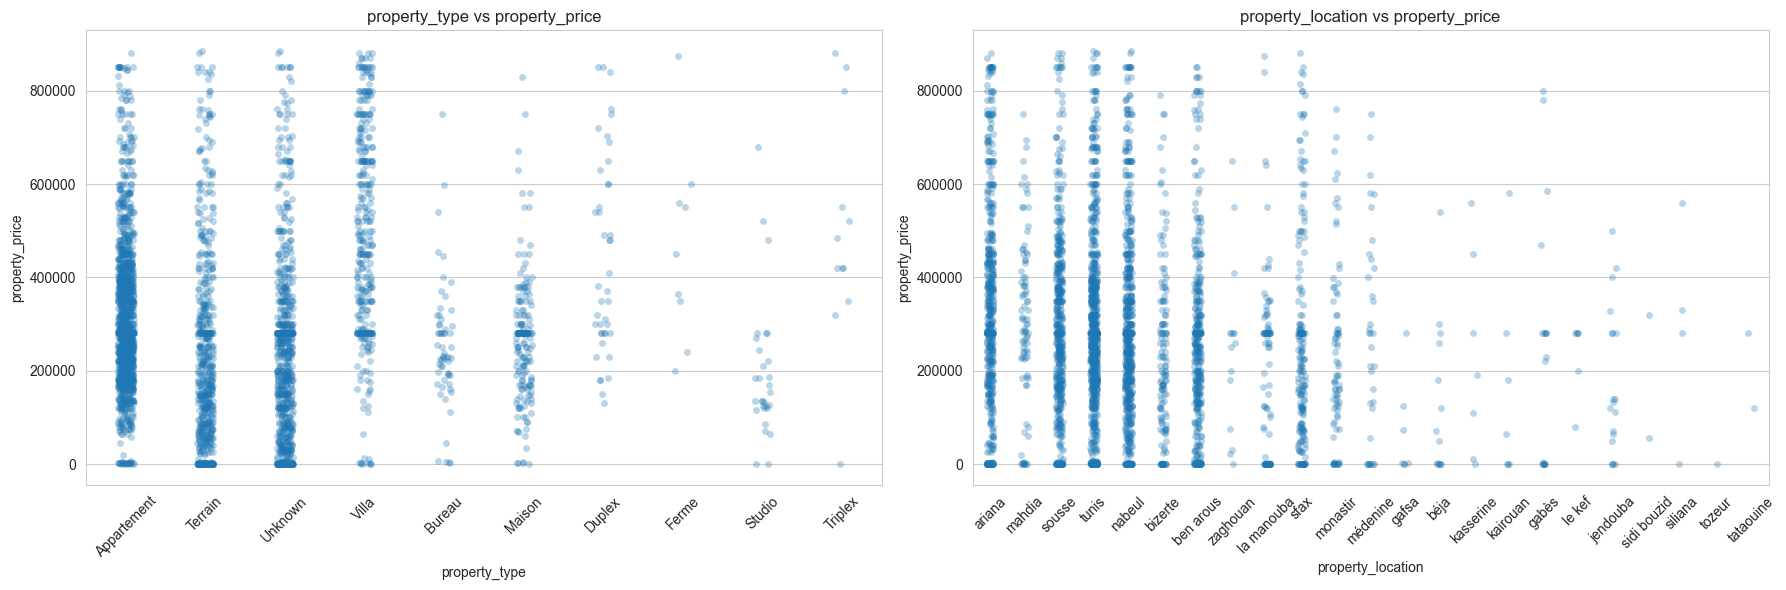

In [ ]:
cat_cols = ['property_type', 'property_location']

plt.figure(figsize=(18,6))
for i, col in enumerate(cat_cols):
    plt.subplot(1, len(cat_cols), i+1)
    sns.stripplot(data=df_clean, x=col, y='property_price', alpha=0.3, jitter=True)
    plt.xticks(rotation=45)
    plt.title(f"{col} vs property_price")
plt.tight_layout()
plt.show()

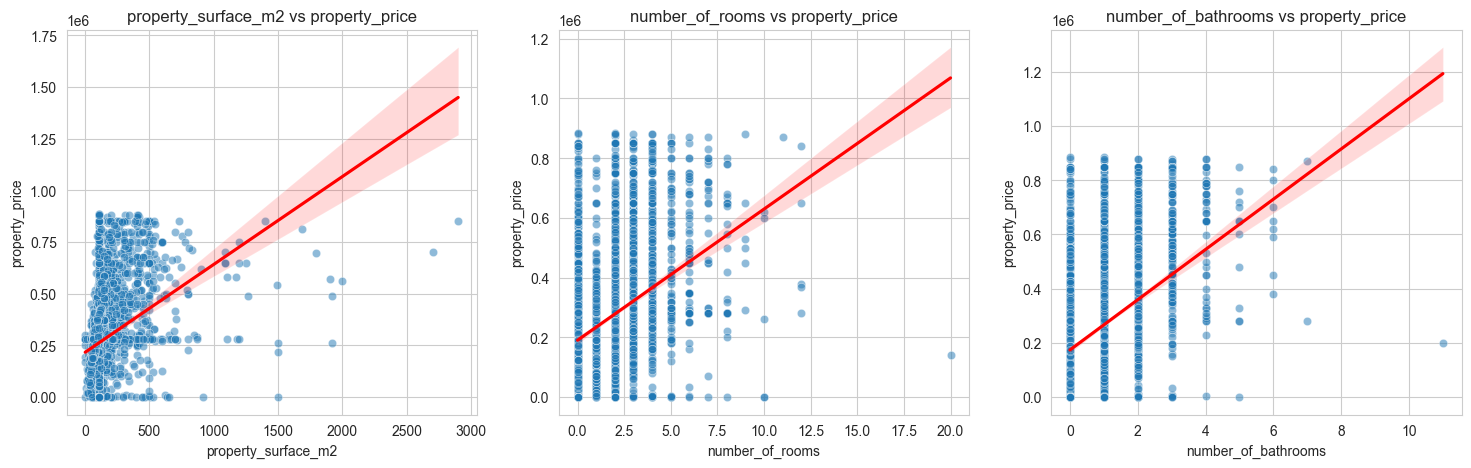

In [ ]:
num_cols_raw = ['property_surface_m2', 'number_of_rooms', 'number_of_bathrooms']

plt.figure(figsize=(18,5))
for i, col in enumerate(num_cols_raw):
    plt.subplot(1, len(num_cols_raw), i+1)
    sns.scatterplot(data=df_clean, x=col, y='property_price', alpha=0.5)
    sns.regplot(data=df_clean, x=col, y='property_price', scatter=False, color='red')
    plt.title(f"{col} vs property_price")
plt.show()

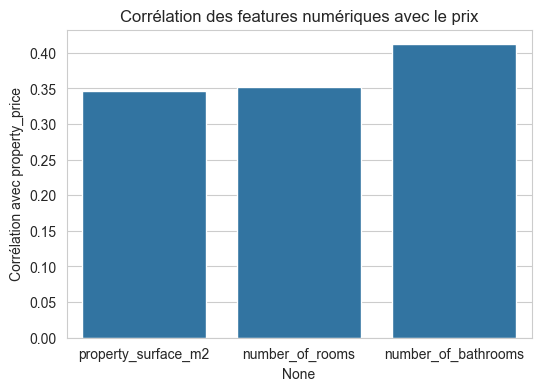

In [ ]:
num_cols_all = ['property_price', 'property_surface_m2', 'number_of_rooms', 'number_of_bathrooms']
corr = df_clean[num_cols_all].corr()

plt.figure(figsize=(6,4))
sns.barplot(x=corr.index[1:], y=corr['property_price'][1:])
plt.title("Corrélation des features numériques avec le prix")
plt.ylabel("Corrélation avec property_price")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_27524\1502115495.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cor_by_location = df_clean[df_clean['property_location'].isin(villes_valides)].groupby('property_location').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_27524\1502115495.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


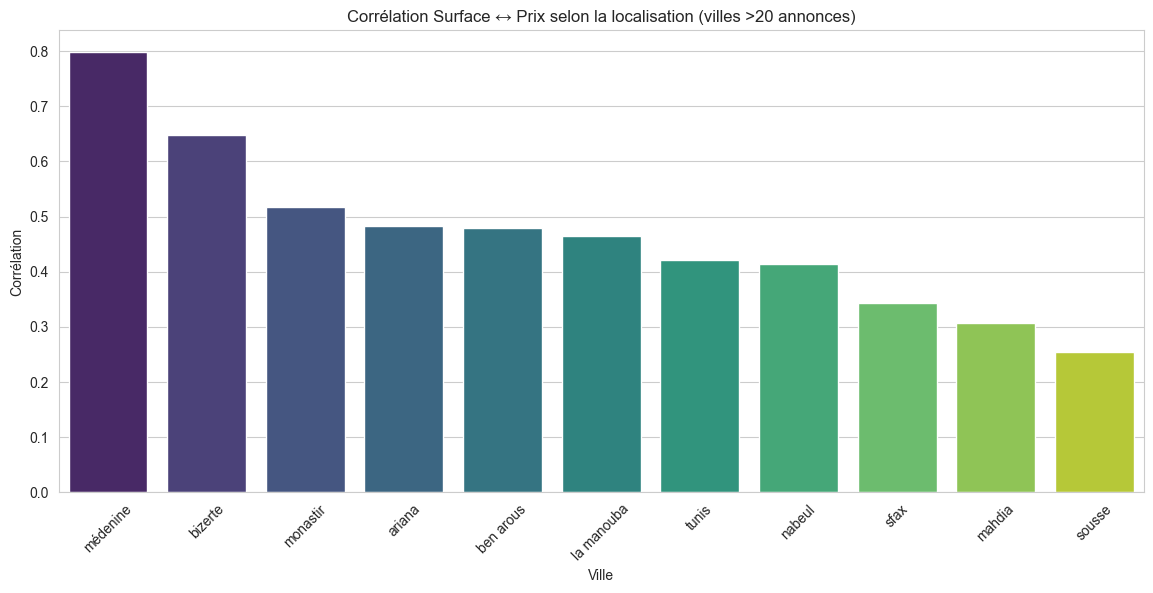

In [658]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


villes_valides = df_clean['property_location'].value_counts()
villes_valides = villes_valides[villes_valides > 20].index

# Calcul de la corrélation surface ↔ prix par ville valide
cor_by_location = df_clean[df_clean['property_location'].isin(villes_valides)].groupby('property_location').apply(
    lambda x: x['property_surface_m2'].corr(x['property_price'])
).reset_index()

cor_by_location.columns = ['property_location', 'surface_price_corr']

# Trier pour mieux visualiser
cor_by_location = cor_by_location.sort_values(by='surface_price_corr', ascending=False)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(
    x='property_location', 
    y='surface_price_corr', 
    data=cor_by_location, 
    palette='viridis'
)
plt.xticks(rotation=45)
plt.title("Corrélation Surface ↔ Prix selon la localisation (villes >20 annonces)")
plt.ylabel("Corrélation")
plt.xlabel("Ville")
plt.show()